In [178]:
%matplotlib notebook
import sigpy.plot as pl
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import scipy.io
from torch.autograd import Variable
# import UFNet
import os
# import bart
from torch import optim
import torch_utils as flare
import resnet
# import bart
import sigpy as sp
import matplotlib.pyplot as plt
# from skimage.measure import compare_ssim
import unet.unet_model as UN
import os
from pytorch3dunet.unet3d.model import UNet3D
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="7"
# import 
# device = torch.device('cpu')
device = torch.device('cuda:0')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Defined function

In [3]:
def load_slab(folder,case,center,slices):
    start = center - int(slices/2)
    for j in range(slices):
        if j == 0:
            knee_ksp = np.load("/home/kewang/cube_knee/%s_ksp_slices/%d_%d.npy"%(folder,case,start))[None,...]
            knee_im = np.load("/home/kewang/cube_knee/%s_img_slices/%d_%d.npy"%(folder,case,start))[None,...]
            knee_mps = np.load("/home/kewang/cube_knee/%s_mps_slices/%d_%d.npy"%(folder,case,start))[None,...]
            knee_masks = np.load("/home/kewang/cube_knee/%s_mask_slices/%d_%d.npy"%(folder,case,start))[None,None,...]
        else:
            knee_ksp = np.concatenate((knee_ksp,np.load("/home/kewang/cube_knee/%s_ksp_slices/%d_%d.npy"%(folder,case,start+j))[None,...]))
            knee_im = np.concatenate((knee_im,np.load("/home/kewang/cube_knee/%s_img_slices/%d_%d.npy"%(folder,case,start+j))[None,...]))
            knee_mps = np.concatenate((knee_mps,np.load("/home/kewang/cube_knee/%s_mps_slices/%d_%d.npy"%(folder,case,start+j))[None,...]))
            knee_masks = np.concatenate((knee_masks,np.load("/home/kewang/cube_knee/%s_mask_slices/%d_%d.npy"%(folder,case,start+j))[None,None,...]))
    return  knee_ksp,knee_im,knee_mps,knee_masks
def bart_valid(knee_ksp,knee_mps,knee_masks):
    ksp_under = (knee_ksp*knee_masks).transpose((1,2,0))[None,...]
    ksp_mps = knee_mps.transpose((1,2,0))[None,...]
    return bart.bart(1,"pics -l1 -r 0.02 -S",ksp_under,ksp_mps)
def CG_adj(ksp,mps,mask):
    SenseModel = flare.SenseModel(mps,mask) 
    adj = SenseModel.adjoint(ksp)
    return SenseModel,adj
def CG_adj_3D(ksp,mps,mask):
    SenseModel = flare.SenseModel_3D(mps,mask) 
    adj = SenseModel.adjoint(ksp)
    return SenseModel,adj
def CG_MoDL_3D(ksp,mps,mask,lam = 0):
    SenseModel = flare.SenseModel_3D(mps,mask)    
    adj = SenseModel.adjoint(ksp)
    CG_alg = flare.ConjGrad(Aop_fun=SenseModel.normal,b=adj,verbose=False,l2lam=lam)
    return CG_alg.forward(adj)
def CG_MoDL(ksp,mps,mask,lam = 0):
    SenseModel = flare.SenseModel(mps,mask)    
    adj = SenseModel.adjoint(ksp)
    CG_alg = flare.ConjGrad(Aop_fun=SenseModel.normal,b=adj,verbose=False,l2lam=lam)
    return CG_alg.forward(adj)
def load_data(folder,dir_data,dev,flag=0,mask=False):
    knee_ksp = np.load("/mikRAID/frank/data/cube_knees/%s_ksp_slices/%s"%(folder,dir_data))
    knee_im = np.load("/mikRAID/frank/data/cube_knees/%s_img_slices/%s"%(folder,dir_data))[None,...]
    knee_mps = np.load("/mikRAID/frank/data/cube_knees/%s_mps_slices/%s"%(folder,dir_data))
    knee_masks = np.load("/mikRAID/frank/data/cube_knees/%s_mask_slices/%s"%(folder,dir_data))[None,...]
    if flag:
        knee_masks = mask
    knee_ksp = bart.bart(1,"fftmod 6",knee_ksp)
    knee_mps = bart.bart(1,"fftmod 6",knee_mps)
    ksp_under = (knee_ksp*knee_masks)[None,...]
    knee_mps = knee_mps[None,...]
    im_torch = flare.np2torch(knee_im)
    ksp_torch = flare.np2torch(ksp_under)
    mps_torch = flare.np2torch(knee_mps)
    mask_torch = flare.np2torch(abs(knee_masks),data_complex=False)
    return ksp_torch.to(dev),mps_torch.to(dev),mask_torch.to(dev),im_torch.to(dev)
class MoDL_3D(nn.Module):
    def __init__(self,M=None,A = None,lam_l2 = 0,unroll = 3,cg_max = 10):
        super(MoDL_3D, self).__init__()
        self.Model = M
        self.A = A
        self.lam2 = lam_l2
        self.urnum = unroll
        self.cg = cg_max

    def forward(self, adj):
        out = adj
#         print(out.shape)
        for i in range(self.urnum):
            print(i)
            out = self.Model(out).squeeze(0).permute(1,2,3,0)
#             out1 = out
#             print(adj.shape)
#             print(out.shape)
#             print(out.shape)
#             print(adj.squeeze(0).permute(1,2,3,0).shape)
            rhs = adj.squeeze(0).permute(1,2,3,0) + self.lam2 * out
            CG_alg = flare.ConjGrad(Aop_fun=self.A.normal,b=rhs,verbose=False,l2lam=self.lam2,max_iter=self.cg)
            out = CG_alg.forward(rhs).permute(3,0,1,2).unsqueeze(0)
#             print(out.shape)
        return out

In [248]:
def nmrse(x,gt):
    return np.linalg.norm(x-gt)/np.linalg.norm(gt)
def psnr(x,gt):
    mse = np.linalg.norm(x-gt)**2/(x.shape[0]*x.shape[1])
#     print(mse)
    return 20 * np.log10(abs(gt).max()/np.sqrt(mse)) 

# Visualize 3D data

In [4]:
for j in range(320):
    knee_im_ind = np.load("/home/kewang/cube_knee/test_img_slices/20_%d.npy"%(j))
    if j == 0:
        knee_img_all = knee_im_ind[None,...]
    else:
        knee_img_all = np.concatenate((knee_img_all,knee_im_ind[None,...]))
#     print(j)

In [192]:
knee_bart_all = np.load("../3D_DIR_results/im_bart_all_test_20.npy")
knee_modl_all = np.load("../3D_DIR_results/im_2dmodl_all_test_20_pr005.npy")

In [279]:
psnr_all = np.zeros((220,3))
rmse_all = np.zeros((220,3))
for j in range(50,270):
    psnr_all[j-50,0] = psnr(knee_bart_all[:,:,j],knee_img_all[:,:,j])    
    psnr_all[j-50,1] = psnr(knee_modl_all[:,:,j],knee_img_all[:,:,j])    
    psnr_all[j-50,2] = psnr(im_all_3ddir[:,:,j],knee_img_all[:,:,j])
    rmse_all[j-50,0] = nmrse(knee_bart_all[:,:,j],knee_img_all[:,:,j])    
    rmse_all[j-50,1] = nmrse(knee_modl_all[:,:,j],knee_img_all[:,:,j])    
    rmse_all[j-50,2] = nmrse(im_all_3ddir[:,:,j],knee_img_all[:,:,j])

In [270]:
psnr_all = np.zeros((190,3))
for j in range(30,220):
    psnr_all[j-30,0] = psnr(knee_bart_all[:,j,:],knee_img_all[:,j,:])    
    psnr_all[j-30,1] = psnr(knee_modl_all[:,j,:],knee_img_all[:,j,:])    
    psnr_all[j-30,2] = psnr(im_all_3ddir[:,j,:],knee_img_all[:,j,:])

In [274]:
rmse_all = np.zeros((150,3))
for j in range(50,200):
    rmse_all[j-50,0] = nmrse(knee_bart_all[:,j,:],knee_img_all[:,j,:])    
    rmse_all[j-50,1] = nmrse(knee_modl_all[:,j,:],knee_img_all[:,j,:])    
    rmse_all[j-50,2] = nmrse(im_all_3ddir[:,j,:],knee_img_all[:,j,:])

In [253]:
nmrse(knee_img_all[30,:,:],im_all_3ddir[30,:,:])

0.21501976

# Make box figure:

<IPython.core.display.Javascript object>


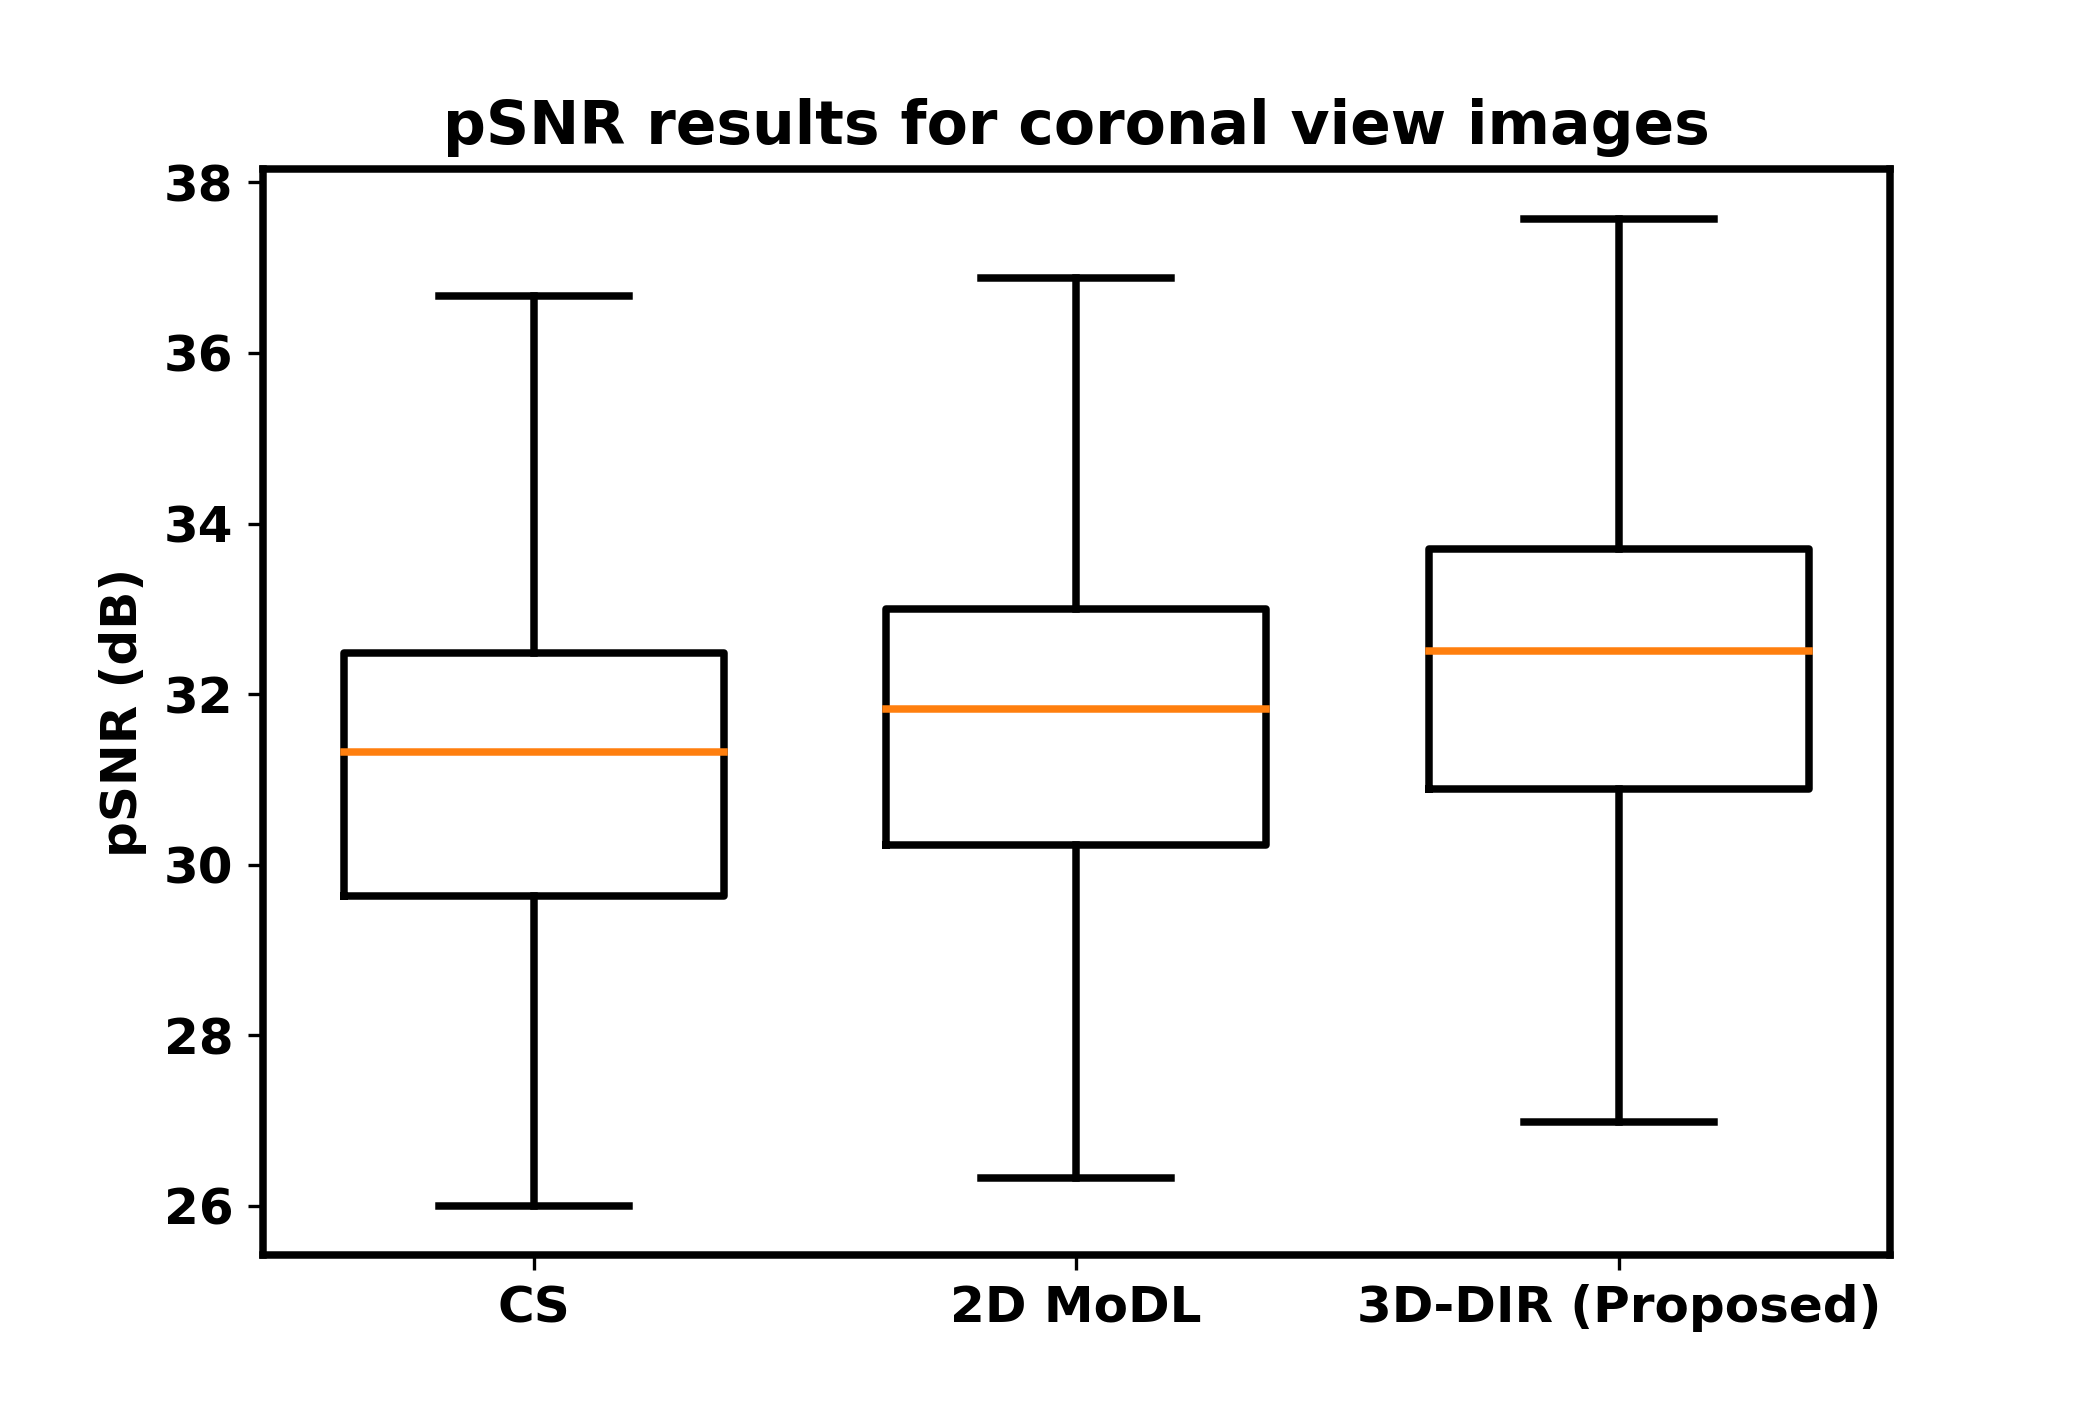

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6dcd7cc210>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6dcd7d4890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6dcd7cc110>,
 'medians': [<matplotlib.lines.Line2D at 0x7f6dcd7cce90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6dcd758810>,
 'means': []}

In [282]:
boxprops1 = dict(linewidth=1.8)
fig= plt.figure(figsize=(7,4.7))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 12})
plt.title("pSNR results for coronal view images",fontname="Times New Roman",fontweight="bold")
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.8)
#     ax.spines[axis].set_color("gold")
    ax.spines[axis].set_zorder(0)
plt.rcParams.update({'font.size': 12})
plt.ylabel("pSNR (dB)",fontname="Times New Roman",fontweight="bold")
plt.boxplot(psnr_all,widths=0.7,labels=('CS','2D MoDL','3D-DIR (Proposed)'),boxprops=boxprops1, flierprops=boxprops1, medianprops=boxprops1, meanprops=boxprops1, capprops=boxprops1, whiskerprops=boxprops1)

<IPython.core.display.Javascript object>


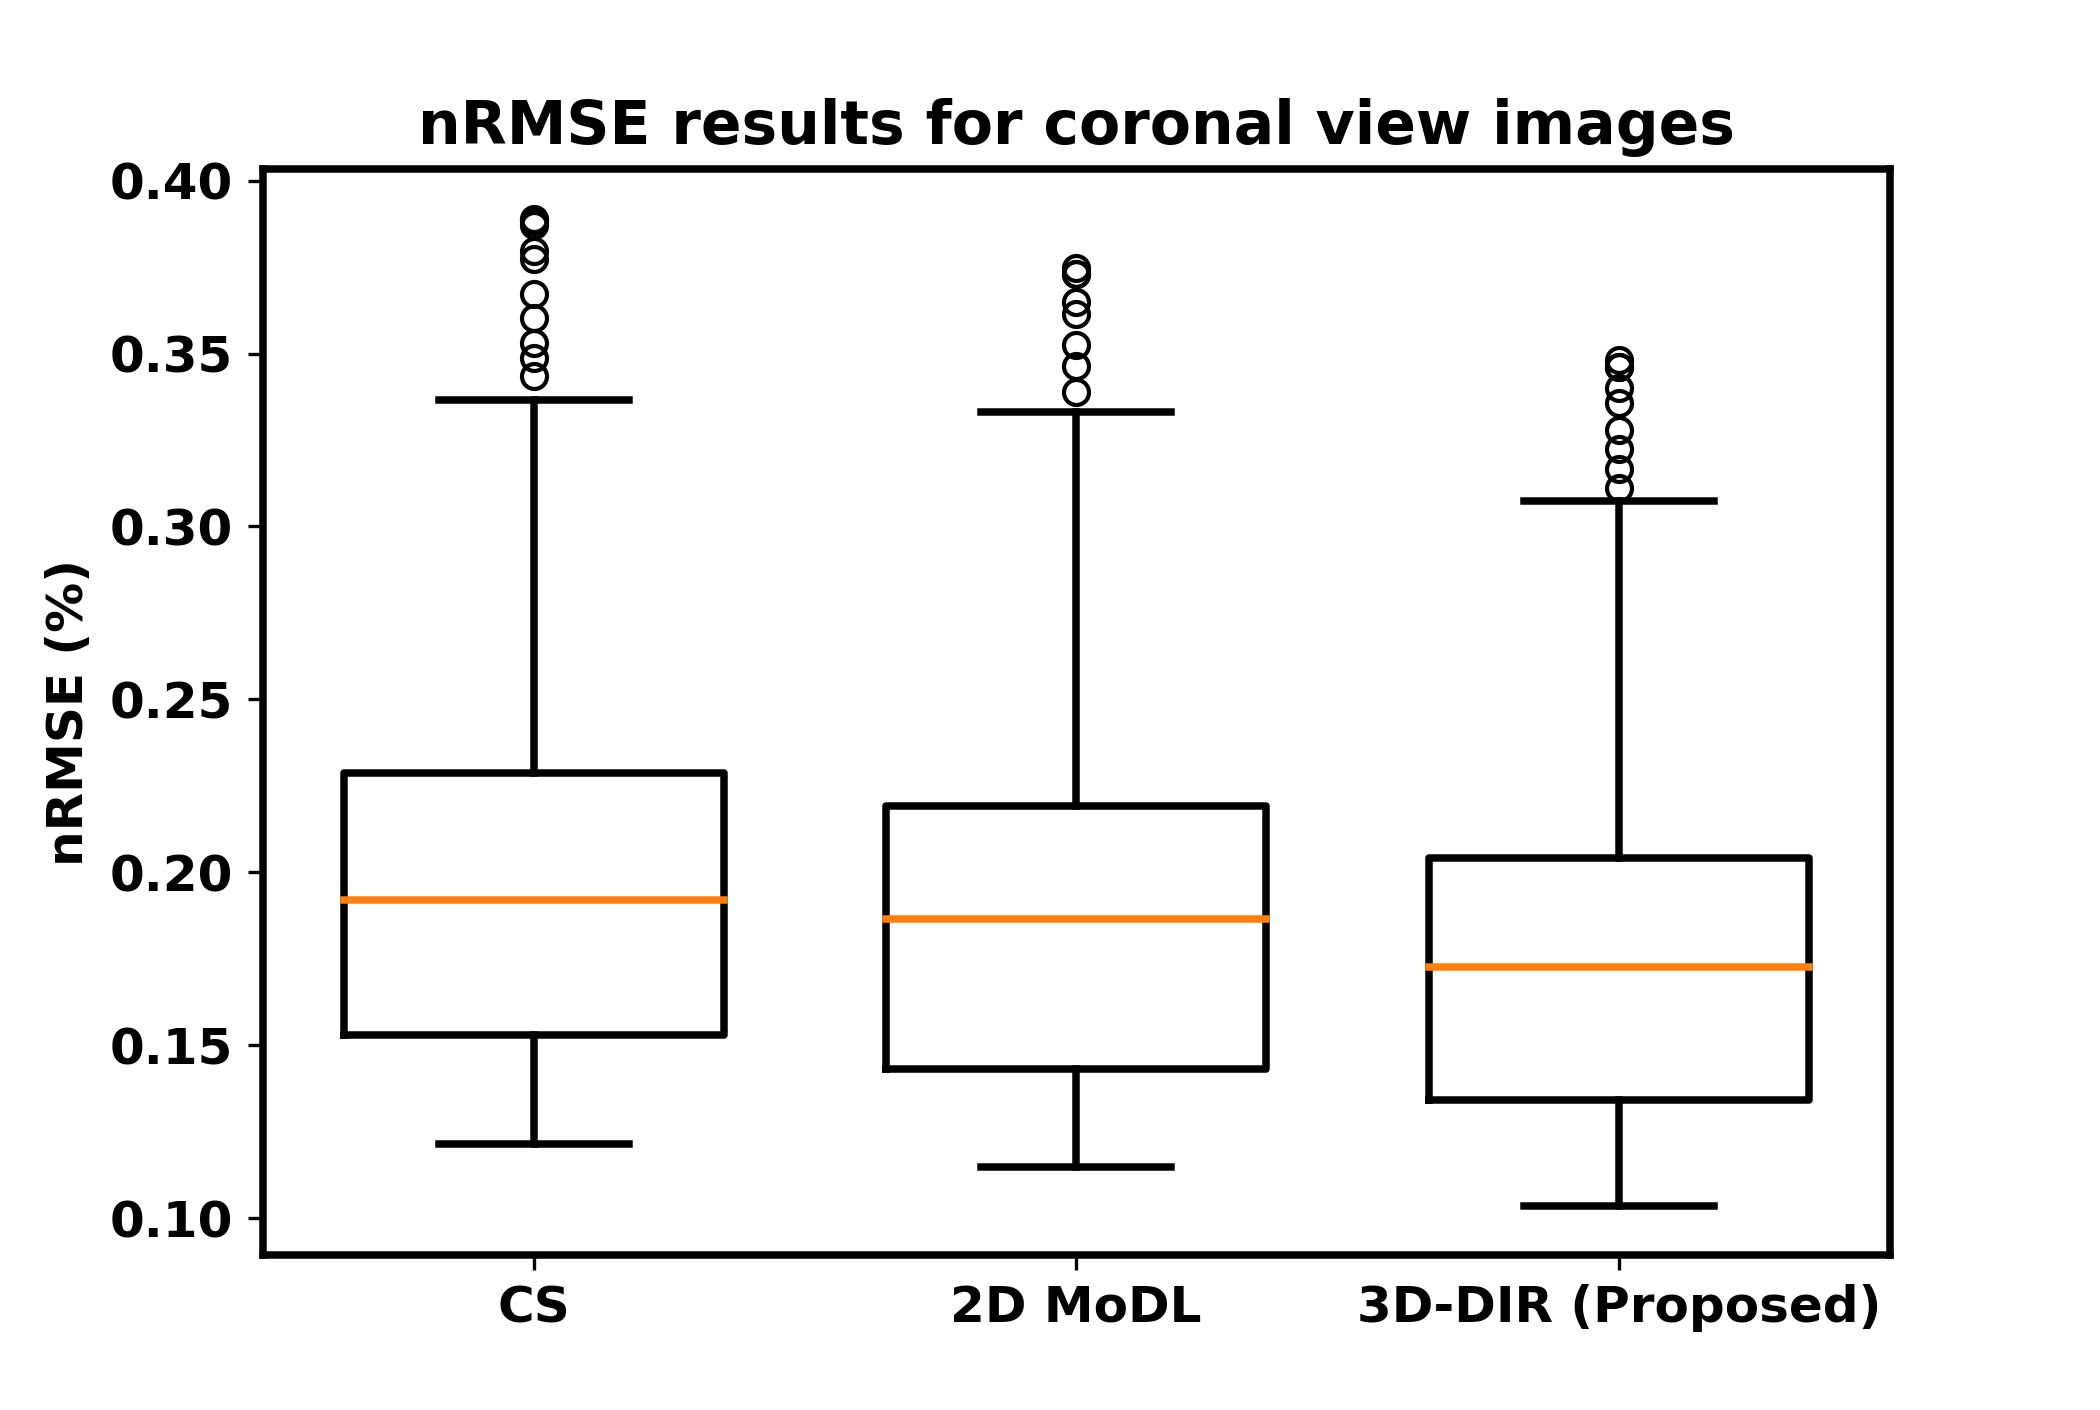

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6dd33ddf90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6dd33ee650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6dd33ddd50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f6dd33ebc50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6dd33f6610>,
 'means': []}

In [281]:
boxprops1 = dict(linewidth=1.8)
fig= plt.figure(figsize=(7,4.7))
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 12})
plt.title("nRMSE results for coronal view images",fontname="Times New Roman",fontweight="bold")
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.8)
#     ax.spines[axis].set_color("gold")
    ax.spines[axis].set_zorder(0)
plt.rcParams.update({'font.size': 12})
plt.ylabel("nRMSE (%)",fontname="Times New Roman",fontweight="bold")
plt.boxplot(rmse_all,widths=0.7,labels=('CS','2D MoDL','3D-DIR (Proposed)'),boxprops=boxprops1, flierprops=boxprops1, medianprops=boxprops1, meanprops=boxprops1, capprops=boxprops1, whiskerprops=boxprops1)

In [246]:
im_all = np.concatenate((knee_img_all[None,...],knee_bart_all[None,...],knee_modl_all[None,...],im_all_3ddir[None,...]),0)

<IPython.core.display.Javascript object>


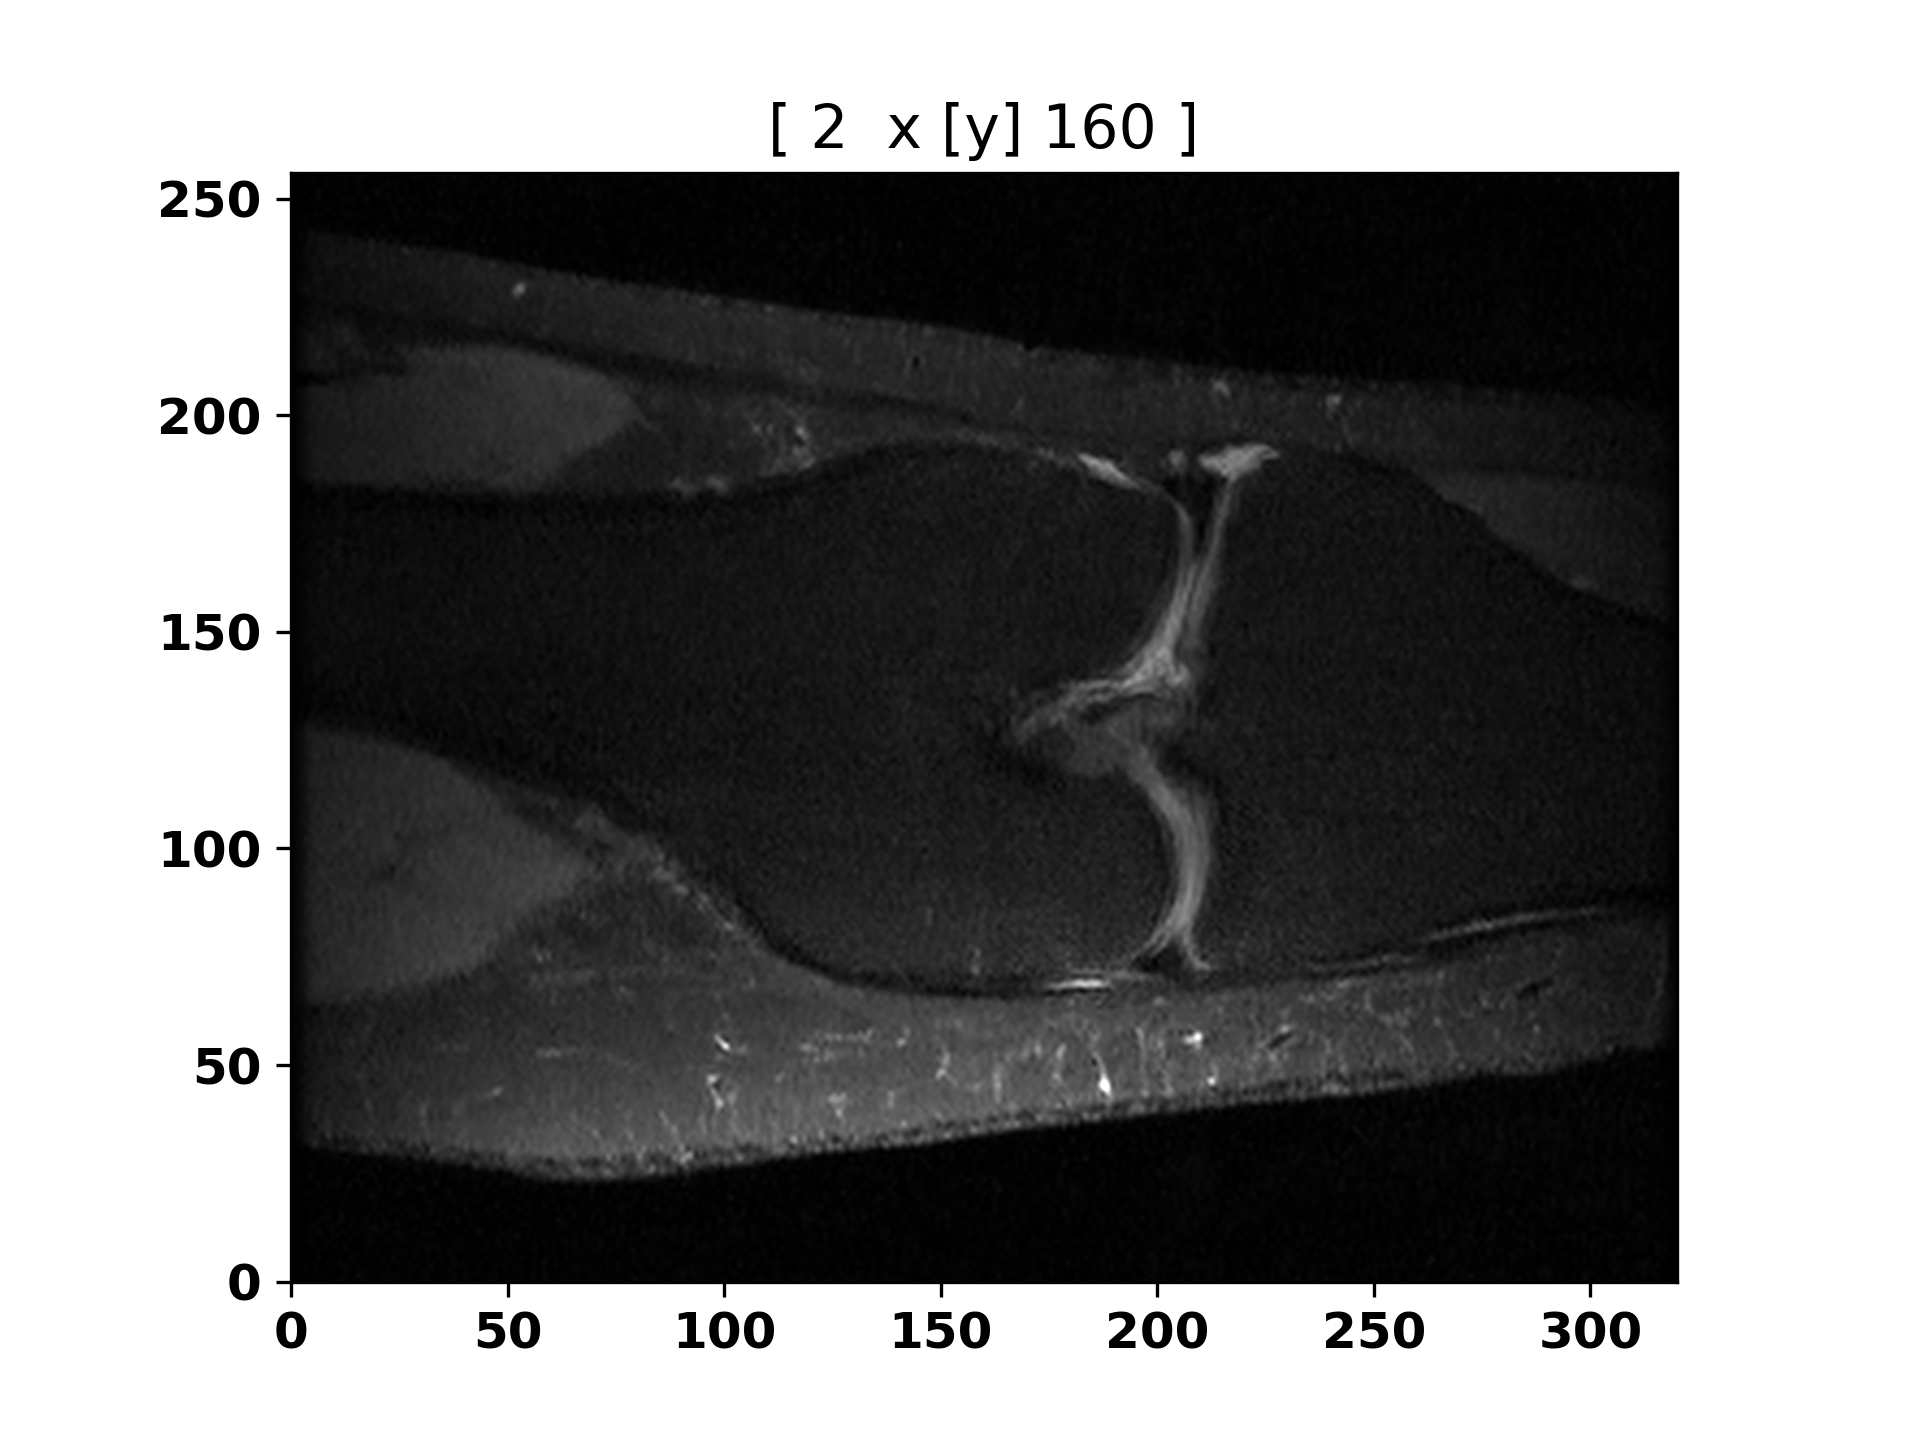

In [247]:
pl.ImagePlot(im_all,interpolation="lanczos")

# Perform Testing

In [6]:
# Hyper parameters of the training
folder = "test"
case = 20
slices = 15
unroll = 3
cg = 6
lamda = 0.05
Loss = nn.L1Loss()


In [61]:
Model = UNet3D(in_channels=2,out_channels=2,is_segmentation=False,final_sigmoid=False).to(device)
Model.load_state_dict((torch.load("/home/kewang/3D_DIR_results/checkpoints_0503/cp_unroll_sl6_3_cg_6_epochs_6.pth", map_location=device)))

<All keys matched successfully>

<IPython.core.display.Javascript object>


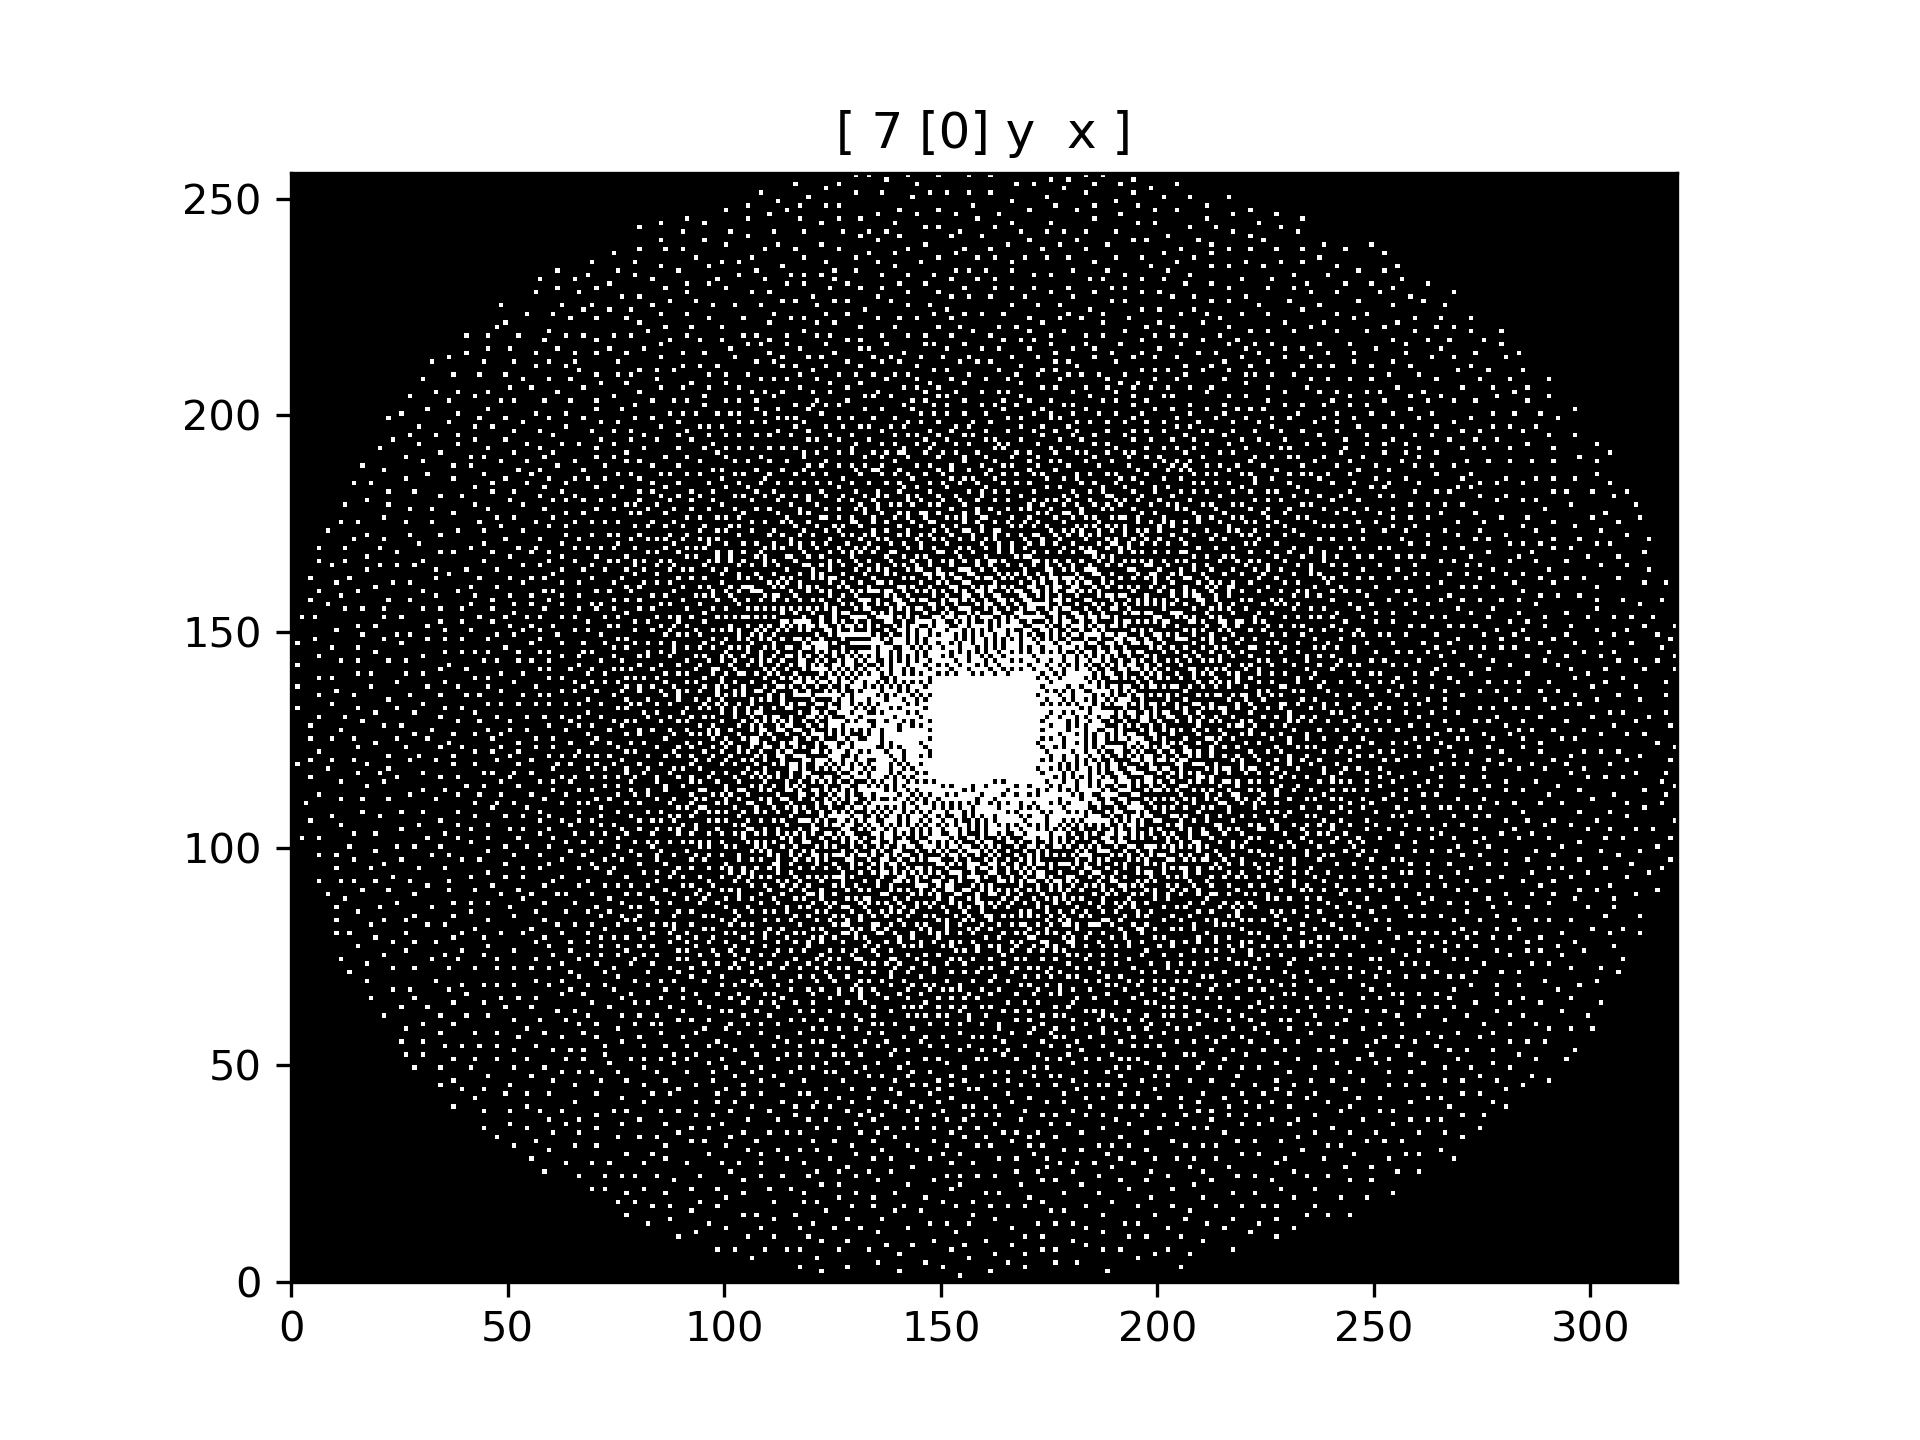

In [62]:
pl.ImagePlot(knee_masks)

<IPython.core.display.Javascript object>


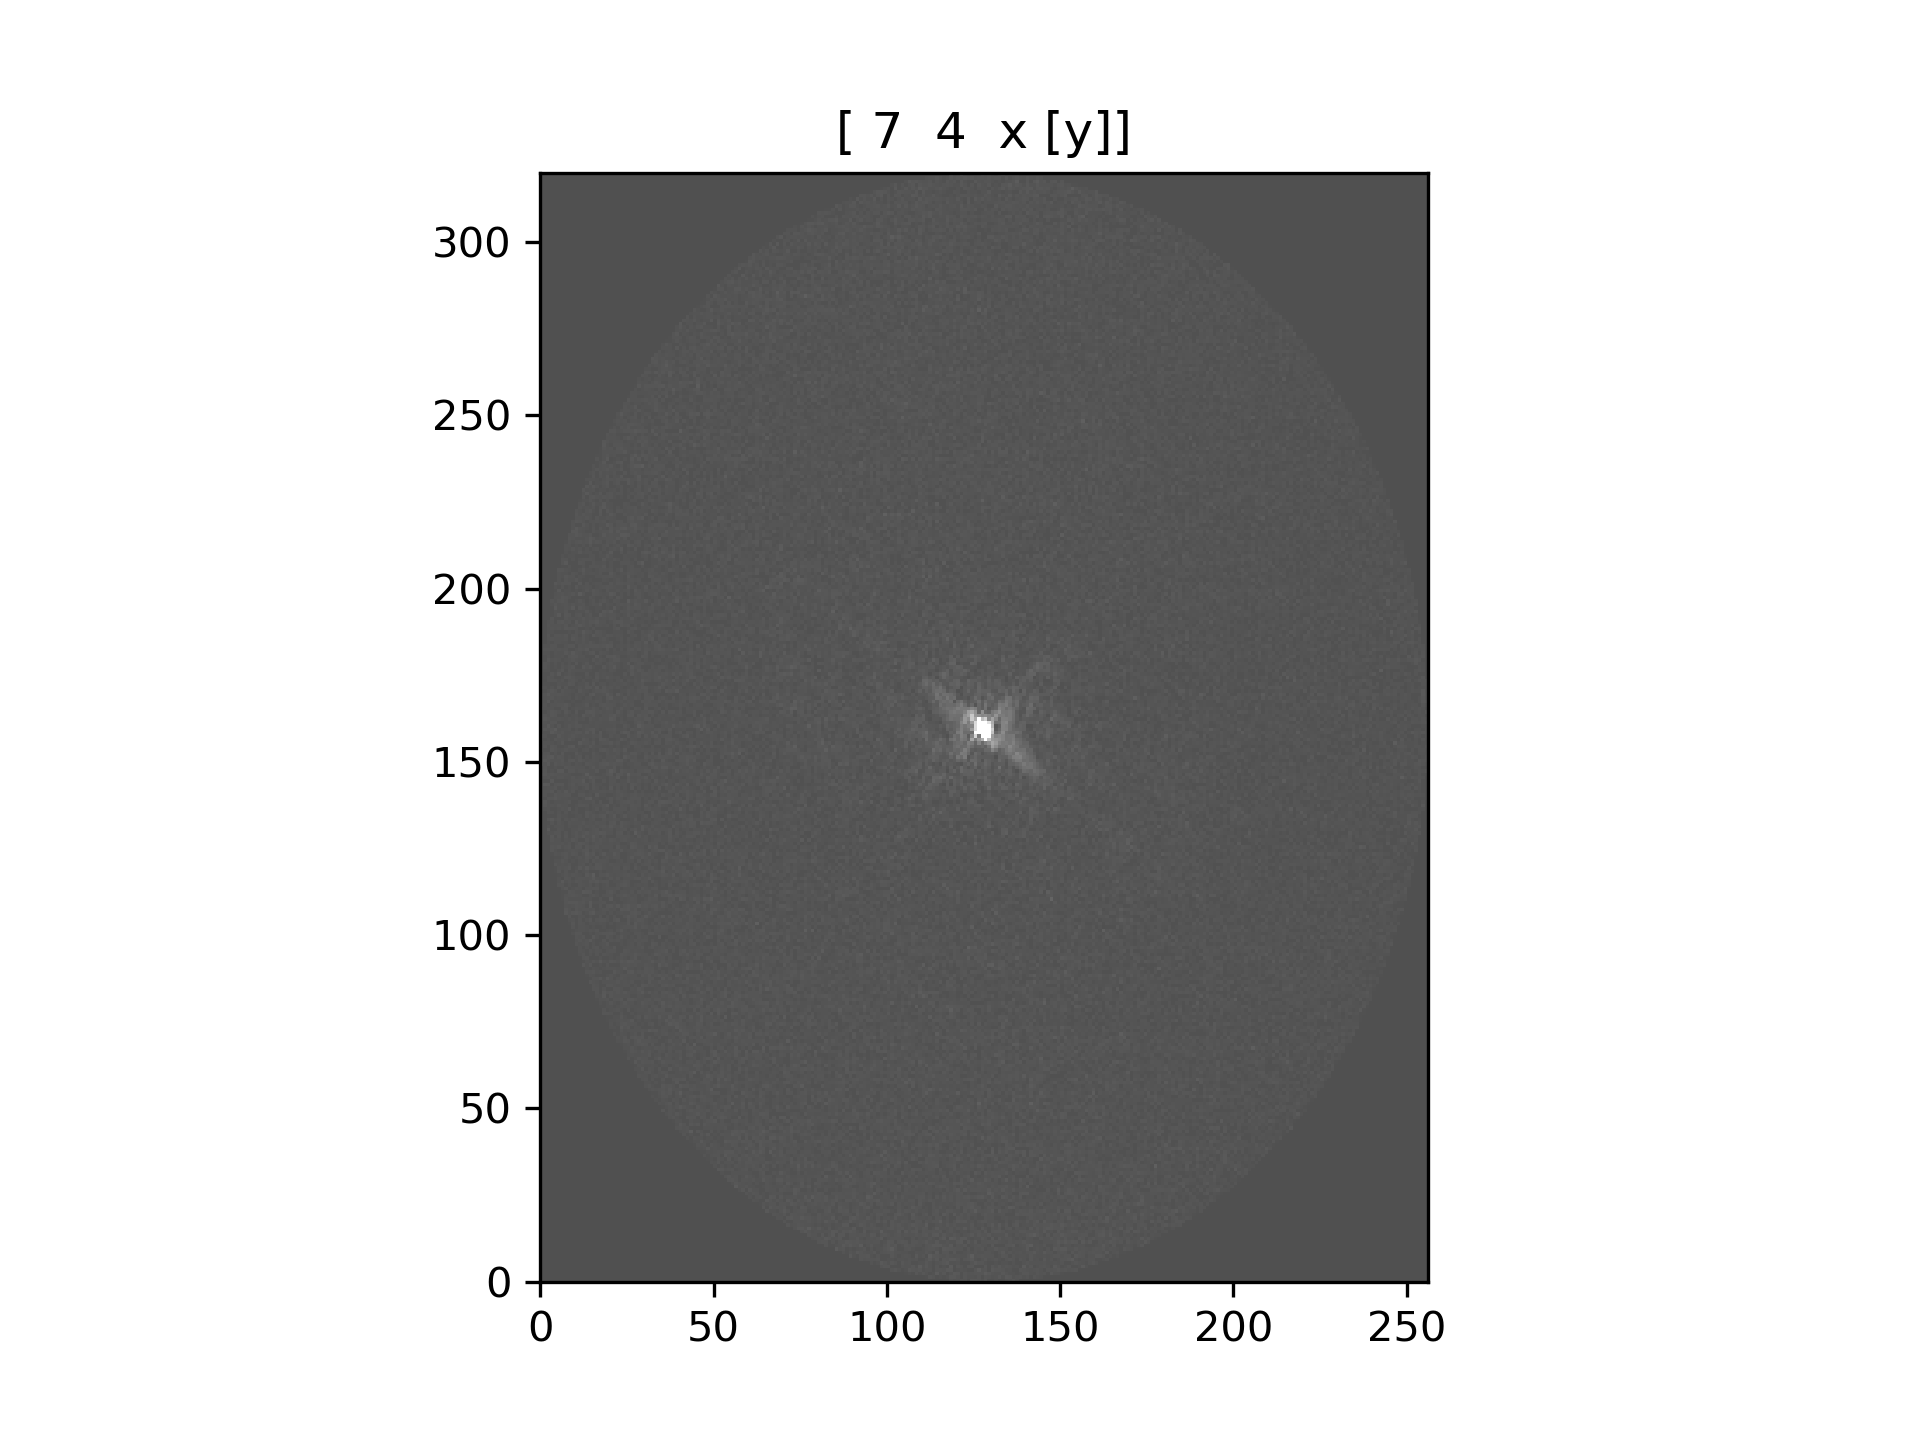

In [77]:
pl.ImagePlot(knee_ksp)

In [78]:
with torch.no_grad():
    knee_ksp,knee_im,knee_mps,knee_masks = load_slab(folder,case,180,slices)
    im_torch = flare.np2torch(knee_im).to(device).permute(3,0,1,2).unsqueeze(0)
    ksp_under = (knee_ksp*knee_masks)
    ksp_torch = flare.np2torch(ksp_under).to(device)
    mps_torch = flare.np2torch(knee_mps).to(device)
    mask_torch = flare.np2torch(abs(knee_masks),data_complex=False).to(device)
    Sense,adj = CG_adj_3D(ksp_torch,mps_torch,mask_torch)
    out = adj
    #         print(out.shape)
    #Perform unrolls
    for un in range(unroll):
        out = Model(out)+out
    #             print(adj.shape)
    #             print(out.shape)
        rhs = adj+ lamda * out
        CG_alg = flare.ConjGrad(Aop_fun=Sense.normal,b=rhs,verbose=False,l2lam=lamda,max_iter=cg)
        out = CG_alg.forward(rhs)

In [79]:
im_torch.shape

torch.Size([1, 2, 15, 256, 320])

In [80]:
Loss(out,im_torch)

tensor(0.0068, device='cuda:0')

In [89]:
im_all = flare.torch2np(adj[0,...].permute(1,2,3,0))

In [90]:
im_all.shape

(15, 256, 320)

<IPython.core.display.Javascript object>


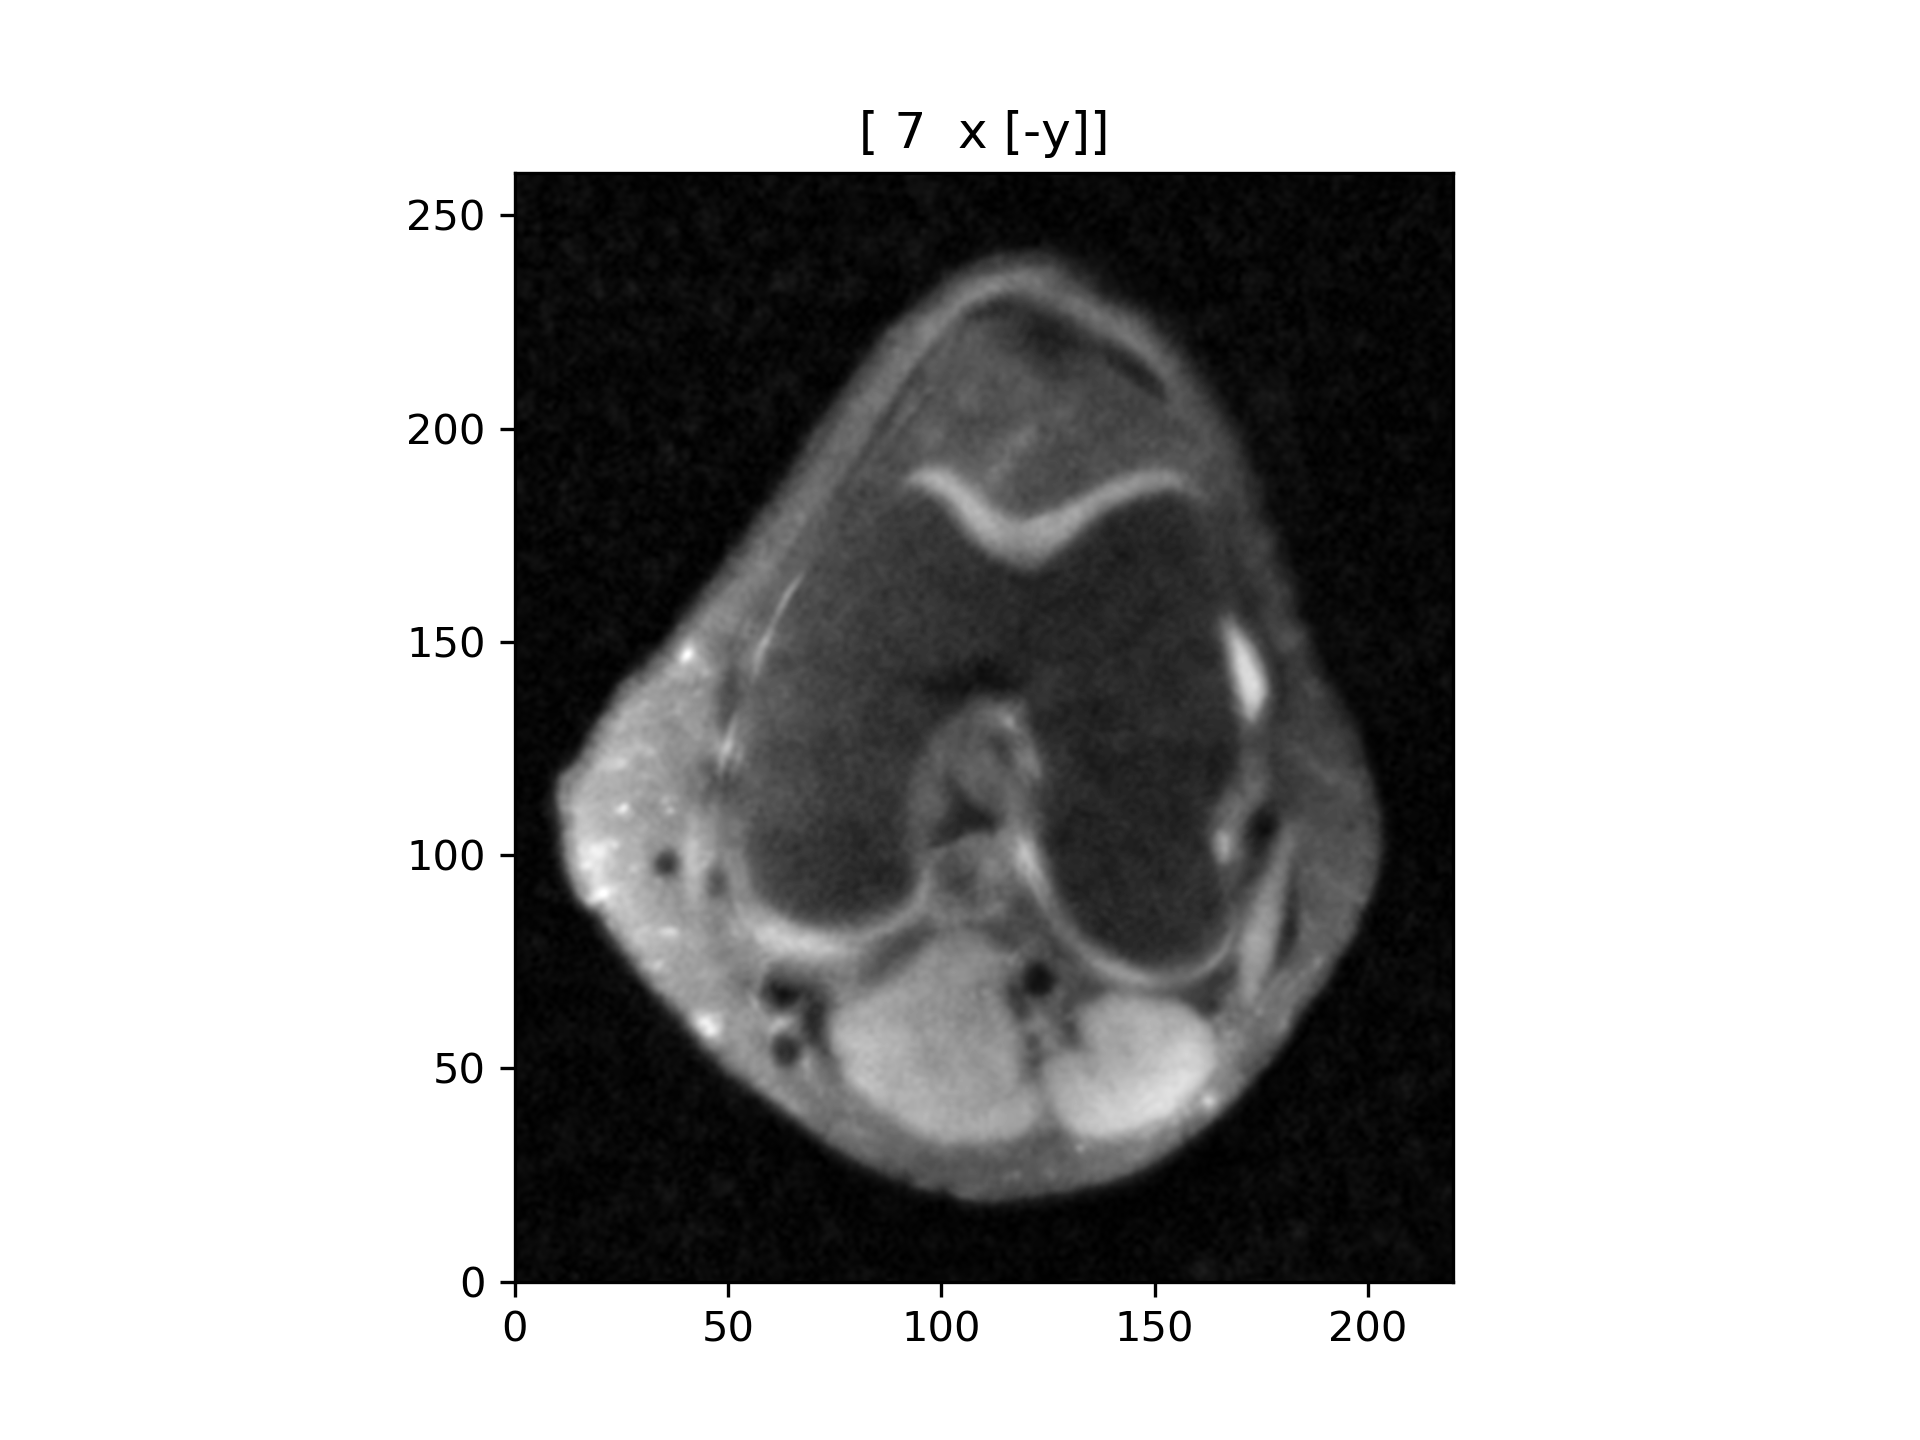

In [91]:
an = 110
bn = 130
pl.ImagePlot(im_all[:,128-an:128+an,160-bn:160+bn],interpolation="lanczos")

In [69]:
with torch.no_grad():
    for center in range(7,308,15):
        print(center)
        knee_ksp,knee_im,knee_mps,knee_masks = load_slab(folder,case,center,slices)
        im_torch = flare.np2torch(knee_im).to(device).permute(3,0,1,2).unsqueeze(0)
        ksp_under = (knee_ksp*knee_masks)
        ksp_torch = flare.np2torch(ksp_under).to(device)
        mps_torch = flare.np2torch(knee_mps).to(device)
        mask_torch = flare.np2torch(abs(knee_masks),data_complex=False).to(device)
        Sense,adj = CG_adj_3D(ksp_torch,mps_torch,mask_torch)
#         adj_input = adj.permute(3,0,1,2).unsqueeze(0)
        out = adj
    #         print(out.shape)
    #Perform unrolls
        for un in range(unroll):
            out = Model(out)+out
        #             print(adj.shape)
        #             print(out.shape)
            rhs = adj+ lamda * out
            CG_alg = flare.ConjGrad(Aop_fun=Sense.normal,b=rhs,verbose=False,l2lam=lamda,max_iter=cg)
            out = CG_alg.forward(rhs)
        if center == 7:
            im_all_3ddir = flare.torch2np(out[0,...].permute(1,2,3,0))
        else:
            im_all_3ddir = np.concatenate((im_all_3ddir,flare.torch2np(out[0,...].permute(1,2,3,0))))
    center = 312
    knee_ksp,knee_im,knee_mps,knee_masks = load_slab(folder,case,center,slices)
    im_torch = flare.np2torch(knee_im).to(device).permute(3,0,1,2).unsqueeze(0)
    ksp_under = (knee_ksp*knee_masks)
    ksp_torch = flare.np2torch(ksp_under).to(device)
    mps_torch = flare.np2torch(knee_mps).to(device)
    mask_torch = flare.np2torch(abs(knee_masks),data_complex=False).to(device)
    Sense,adj = CG_adj_3D(ksp_torch,mps_torch,mask_torch)
    out = adj
    #         print(out.shape)
    #Perform unrolls
    for un in range(unroll):
        out = Model(out)+out
    #             print(adj.shape)
    #             print(out.shape)
        rhs = adj+ lamda * out
        CG_alg = flare.ConjGrad(Aop_fun=Sense.normal,b=rhs,verbose=False,l2lam=lamda,max_iter=cg)
        out = CG_alg.forward(rhs)
    im_temp = flare.torch2np(out[0,...].permute(1,2,3,0))[-5:,...]
    im_all_3ddir = np.concatenate((im_all_3ddir,im_temp))

7
22
37
52
67
82
97
112
127
142
157
172
187
202
217
232
247
262
277
292
307


<IPython.core.display.Javascript object>


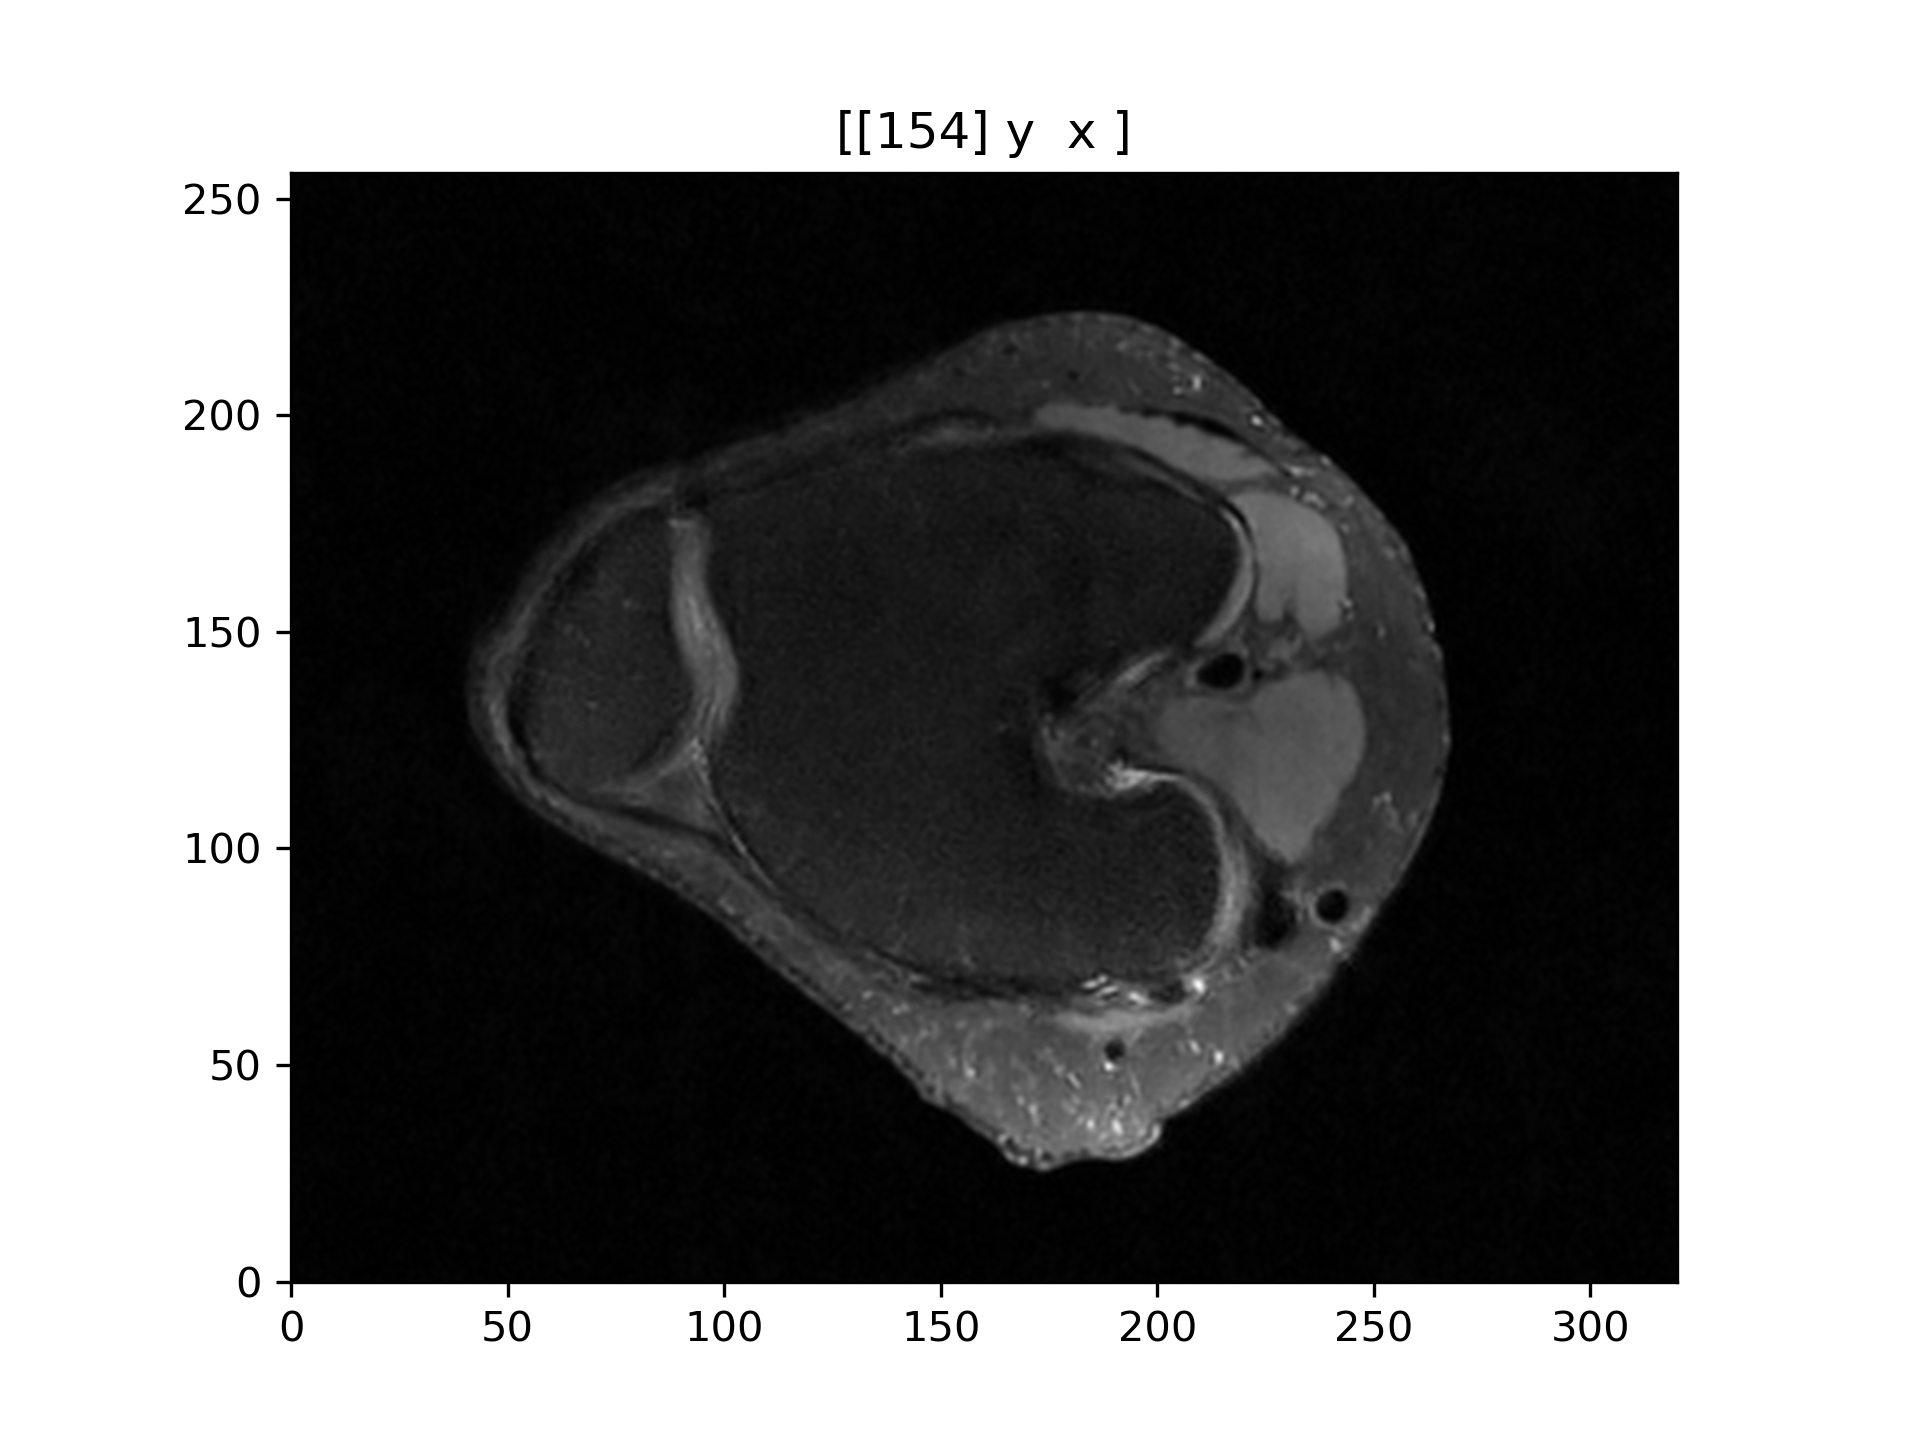

In [15]:
pl.ImagePlot(im_all_3ddir,interpolation="lanczos")